In [16]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import os

import matplotlib.dates as mdates
from matplotlib.colors import Normalize
from matplotlib import cm

from seppy.loader.solo import mag_load
from seppy.tools import resample_df
from stixdcpy.quicklook import LightCurves
from sunpy.coordinates import get_horizons_coord
from sunpy.coordinates import frames

from my_func_py3 import mag_angles, polarity_rtn
from polarity_plotting import polarity_rtn, polarity_panel, polarity_colorwheel
from solo_epd_loader import epd_load, calc_ept_corrected_e, combine_channels
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# import warnings
# warnings.filterwarnings('ignore')

plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['font.size'] = 12
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.rc('axes', titlesize=20)  # fontsize of the axes title
plt.rc('axes', labelsize=20)  # fontsize of the x and y labels
plt.rcParams['agg.path.chunksize'] = 20000

In [17]:
import sunpy.net.attrs as a
import sunpy_soar
from sunpy.net import Fido
from sunpy.timeseries import TimeSeries

def swa_load_grnd_mom(startdate, enddate, path=None):
    """
    Load SolO/SWA L2 ground moments

    Load-in data for Solar Orbiter/SWA sensor ground moments. Supports level 2
    provided by ESA's Solar Orbiter Archive. Optionally downloads missing
    data directly. Returns data as Pandas dataframe.

    Parameters
    ----------
    startdate, enddate : {datetime, str, or int}
        Datetime object (e.g., dt.date(2021,12,31) or dt.datetime(2021,4,15)),
        "standard" datetime string (e.g., "2021/04/15") or integer of the form
        yyyymmdd with empty positions filled with zeros, e.g. '20210415'
        (enddate must always be later than startdate)
    path : {str}, optional
        Local path for storing downloaded data, by default None

    Returns
    -------
    Pandas dataframe
    """    
    instrument = a.Instrument('SWA')
    time = a.Time(startdate, enddate)
    level = a.Level(2)
    product = a.soar.Product('SWA-PAS-GRND-MOM')
    
    result = Fido.search(instrument & time & level & product)
    files = Fido.fetch(result,path=path)
    
    solo_swa = TimeSeries(files, concatenate=True)
    df_solo_swa = solo_swa.to_dataframe()
    return df_solo_swa

In [18]:
# Used previously for energy channel combination, but should be replaced with combine_channels() from solo_epd_loader


# def calc_av_en_flux_EPD(df, energies, en_channel, species, instrument):  # original from Nina Slack Feb 9, 2022, rewritten Jan Apr 8, 2022, updated Feb 26, 2025
#     """This function averages the flux of several energy channels of HET into a combined energy channel
#     channel numbers counted from 0

#     Parameters
#     ----------
#     df : pd.DataFrame DataFrame containing HET data
#         DataFrame containing HET data
#     energies : dict
#         Energy dict returned from epd_loader (from Jan)
#     en_channel : int or list
#         energy channel number(s) to be used
#     species : string
#         'e', 'electrons', 'p', 'i', 'protons', 'ions'
#     instrument : string
#         'ept' or 'het'

#     Returns
#     -------
#     pd.DataFrame
#         flux_out: contains channel-averaged flux

#     Raises
#     ------
#     Exception
#         [description]
#     """
#     if species.lower() in ['e', 'electrons']:
#         en_str = energies['Electron_Bins_Text'].flatten()
#         bins_width = 'Electron_Bins_Width'
#         flux_key = 'Electron_Flux'
#     if species.lower() in ['p', 'protons', 'i', 'ions', 'h']:
#         if instrument.lower() == 'het':
#             en_str = energies['H_Bins_Text'].flatten()
#             bins_width = 'H_Bins_Width'
#             flux_key = 'H_Flux'
#         if instrument.lower() == 'ept':
#             en_str = energies['Ion_Bins_Text'].flatten()
#             bins_width = 'Ion_Bins_Width'
#             flux_key = 'Ion_Flux'
#     if type(en_channel) == list:
#         energy_low = en_str[en_channel[0]].split('-')[0]

#         energy_up = en_str[en_channel[-1]].split('-')[-1]
#         en_channel_string = energy_low + '-' + energy_up

#         if len(en_channel) > 2:
#             raise Exception('en_channel must have len 2 or less!')
#         if len(en_channel) == 2:
#             DE = energies[bins_width]
#             try:
#                 df = df[flux_key]
#             except (AttributeError, KeyError):
#                 None
#             for bins in np.arange(en_channel[0], en_channel[-1]+1):
#                 if bins == en_channel[0]:
#                     I_all = df[f'{flux_key}_{bins}'] * DE[bins]
#                 else:
#                     I_all = I_all + df[f'{flux_key}_{bins}'] * DE[bins]
#             DE_total = np.sum(DE[(en_channel[0]):(en_channel[-1]+1)])
#             flux_out = pd.DataFrame({'flux': I_all/DE_total}, index=df.index)
#         else:
#             en_channel = en_channel[0]
#             flux_out = pd.DataFrame({'flux': df[f'{flux_key}'][f'{flux_key}_{en_channel}']}, index=df.index)
#             #flux_out = pd.DataFrame({'flux': df[f'{flux_key}_{en_channel}']}, index=df.index)
#             en_channel_string = en_str[en_channel]
#     else:
#         en_channel_string = en_str[en_channel]
#         flux_out = pd.DataFrame({'flux': df[f'{flux_key}'][f'{flux_key}_{en_channel}']}, index=df.index)
#         #flux_out = pd.DataFrame({'flux': df[f'{flux_key}_{en_channel}']}, index=df.index)
#     return flux_out, en_channel_string

In [19]:
data_path = '/Users/jagies/data/solo'  # f"{os.getcwd()}/data/"

startdate = dt.datetime(2023, 10, 3)
enddate = dt.datetime(2023, 10, 5)

# date = f"{startdate.year}{startdate.month:02d}{startdate.day:02d}"
viewing = 'sun'

resample = '1min'
resample_particles = '5min'

stix_ltc = True  # correct SolO/STIX data for light travel time

pos_timestamp = None  #'center'

plot_stix = True
plot_electrons = False
plot_protons = True
plot_mag_angles = True 
plot_mag = True
plot_Vsw = True
plot_N = True
plot_T = True
plot_polarity = True 

In [20]:
# This is what we want to use always as of now (JG, Feb 28, 2025)

ept_l3 = True
av_en = False
ion_conta_corr = False

# Data loading

### EPD

In [21]:
if plot_electrons or plot_protons:
    if ept_l3:
        df_ept_org, df_rtn_ept, df_hci_ept, energies_ept, metadata_ept = epd_load(sensor='ept', level='l3', pos_timestamp=pos_timestamp,
                                                                                  startdate=startdate, enddate=enddate,
                                                                                  autodownload=True, path=data_path)
    else:
        protons_ept, electrons_ept, energies_ept = epd_load(sensor='ept', level='l2', startdate=startdate, enddate=enddate, 
                                                            pos_timestamp=pos_timestamp,viewing=viewing, path=data_path, autodownload=True)
    protons_het, electrons_het, energies_het = epd_load(sensor='het', level='l2', startdate=startdate, enddate=enddate, 
                                                        pos_timestamp=pos_timestamp,viewing=viewing, path=data_path, autodownload=True)

### STIX

In [22]:
if plot_stix:
    lc = LightCurves.from_sdc(start_utc=startdate, end_utc=enddate, ltc=stix_ltc)
    df_stix_orig = lc.to_pandas()

### MAG

In [23]:
if plot_mag or plot_mag_angles or plot_polarity:
    mag_data_org = mag_load(startdate, enddate, level='l2', frame='rtn', path=data_path)
    mag_data_org['Bmag'] = np.sqrt(np.nansum((mag_data_org.B_RTN_0.values**2, mag_data_org.B_RTN_1.values**2, mag_data_org.B_RTN_2.values**2), axis=0))

### SWA

In [24]:
if plot_Vsw or plot_N or plot_T:
    swa_data = swa_load_grnd_mom(startdate, enddate, path=data_path)
    swa_vsw = np.sqrt(swa_data.V_RTN_0**2 + swa_data.V_RTN_1**2 + swa_data.V_RTN_2**2)
    swa_data['vsw'] = swa_vsw

    temp = np.sqrt(swa_data.TxTyTz_RTN_0**2 + swa_data.TxTyTz_RTN_2**2 + swa_data.TxTyTz_RTN_2**2)
    swa_data['temp'] = temp

Files Downloaded:   0%|          | 0/3 [00:00<?, ?file/s]

2025-02-28 16:01:42 - sunpy - WARNING: SunpyUserWarning: astropy did not recognize units of "Ticks". Assigning dimensionless units. If you think this unit should not be dimensionless, please raise an issue at https://github.com/sunpy/sunpy/issues


# Resampling

In [25]:
if plot_electrons or plot_protons:
    df_electrons_het = resample_df(electrons_het, resample_particles, pos_timestamp=pos_timestamp)
    df_protons_het = resample_df(protons_het, resample_particles, pos_timestamp=pos_timestamp)

    if ept_l3:
        df_ept = resample_df(df_ept_org, resample_particles, pos_timestamp=pos_timestamp)
        if viewing.lower() == 'south':
            view = 'D'
        else:
            view = viewing[0].upper()
    else:
        df_electrons_ept = resample_df(electrons_ept, resample_particles, pos_timestamp=pos_timestamp)
        df_protons_ept = resample_df(protons_ept, resample_particles, pos_timestamp=pos_timestamp)

if plot_Vsw or plot_N or plot_T:
    df_swa = resample_df(swa_data, resample, pos_timestamp=pos_timestamp)

if plot_mag:
    mag_data = resample_df(mag_data_org, resample, pos_timestamp=pos_timestamp)

if plot_stix:
    df_stix = resample_df(df_stix_orig, resample, pos_timestamp=pos_timestamp) 

In [26]:
# correct EPT level 2 electron data for ion contamination:
if plot_electrons and ion_conta_corr and not ept_l3:
    # df_electrons_ept2 = calc_EPT_corrected_e(df_electrons_ept['Electron_Flux'], df_protons_ept['Ion_Flux'])
    df_electrons_ept = calc_ept_corrected_e(df_electrons_ept, df_protons_ept)
    df_electrons_ept = df_electrons_ept.mask(df_electrons_ept < 0)

# Energy channel information:

In [27]:
print('EPT electron channels:')
for i, e in enumerate(energies_ept['Electron_Bins_Text']):
    print(i, e)
print('')
print('HET electron channels:')
for i, e in enumerate(energies_het['Electron_Bins_Text']):
    print(i, e)
print('')
print('EPT ion channels:')
for i, e in enumerate(energies_ept['Ion_Bins_Text']):
    print(i, e)
print('')
print('HET ion channels:')
for i, e in enumerate(energies_het['H_Bins_Text']):
    print(i, e)

EPT electron channels:
0 0.0356 - 0.042 MeV
1 0.0408 - 0.0467 MeV
2 0.0467 - 0.0542 MeV
3 0.0542 - 0.0635 MeV
4 0.0635 - 0.0739 MeV
5 0.0739 - 0.0866 MeV
6 0.0866 - 0.1021 MeV
7 0.1021 - 0.1207 MeV
8 0.1207 - 0.1432 MeV
9 0.1432 - 0.169 MeV
10 0.169 - 0.2004 MeV
11 0.2004 - 0.2379 MeV
12 0.2379 - 0.2826 MeV
13 0.2826 - 0.3356 MeV
14 0.3357 - 0.3993 MeV
15 0.3993 - 0.4742 MeV

HET electron channels:
0 0.4533 - 1.0380 MeV
1 1.0530 - 2.4010 MeV
2 2.4010 - 5.9930 MeV
3 5.9930 - 18.8300 MeV

EPT ion channels:
0 0.0552 - 0.0651 MeV
1 0.0608 - 0.0718 MeV
2 0.0689 - 0.0798 MeV
3 0.0768 - 0.087 MeV
4 0.087 - 0.0974 MeV
5 0.0974 - 0.1096 MeV
6 0.1096 - 0.1246 MeV
7 0.1246 - 0.1419 MeV
8 0.1419 - 0.1628 MeV
9 0.1628 - 0.1879 MeV
10 0.1879 - 0.2189 MeV
11 0.2189 - 0.2549 MeV
12 0.2549 - 0.2980 MeV
13 0.2980 - 0.3494 MeV
14 0.3494 - 0.4117 MeV
15 0.4117 - 0.485 MeV
16 0.485 - 0.5734 MeV
17 0.5734 - 0.6767 MeV
18 0.6767 - 0.8037 MeV
19 0.8037 - 0.95 MeV
20 0.95 - 1.1294 MeV
21 1.1294 - 1.3376 MeV
22

In [28]:
ept_ele_channels = [0, 3, 6, 9, 12, 15]
het_ele_channels = [0, 1, 2, 3]
ept_ion_channels = [0, 5, 10, 15, 20, 25, 30]
het_ion_channels = [0, 5, 10, 15, 20, 25, 30, 35]

# Plotting

2025-02-28 16:09:57 - sunpy - INFO: Obtained JPL HORIZONS location for Solar Orbiter (spacecraft) (-144)


INFO: Obtained JPL HORIZONS location for Solar Orbiter (spacecraft) (-144) [sunpy.coordinates.ephemeris]


Text(0.5, 1.0, 'Solar Orbiter')

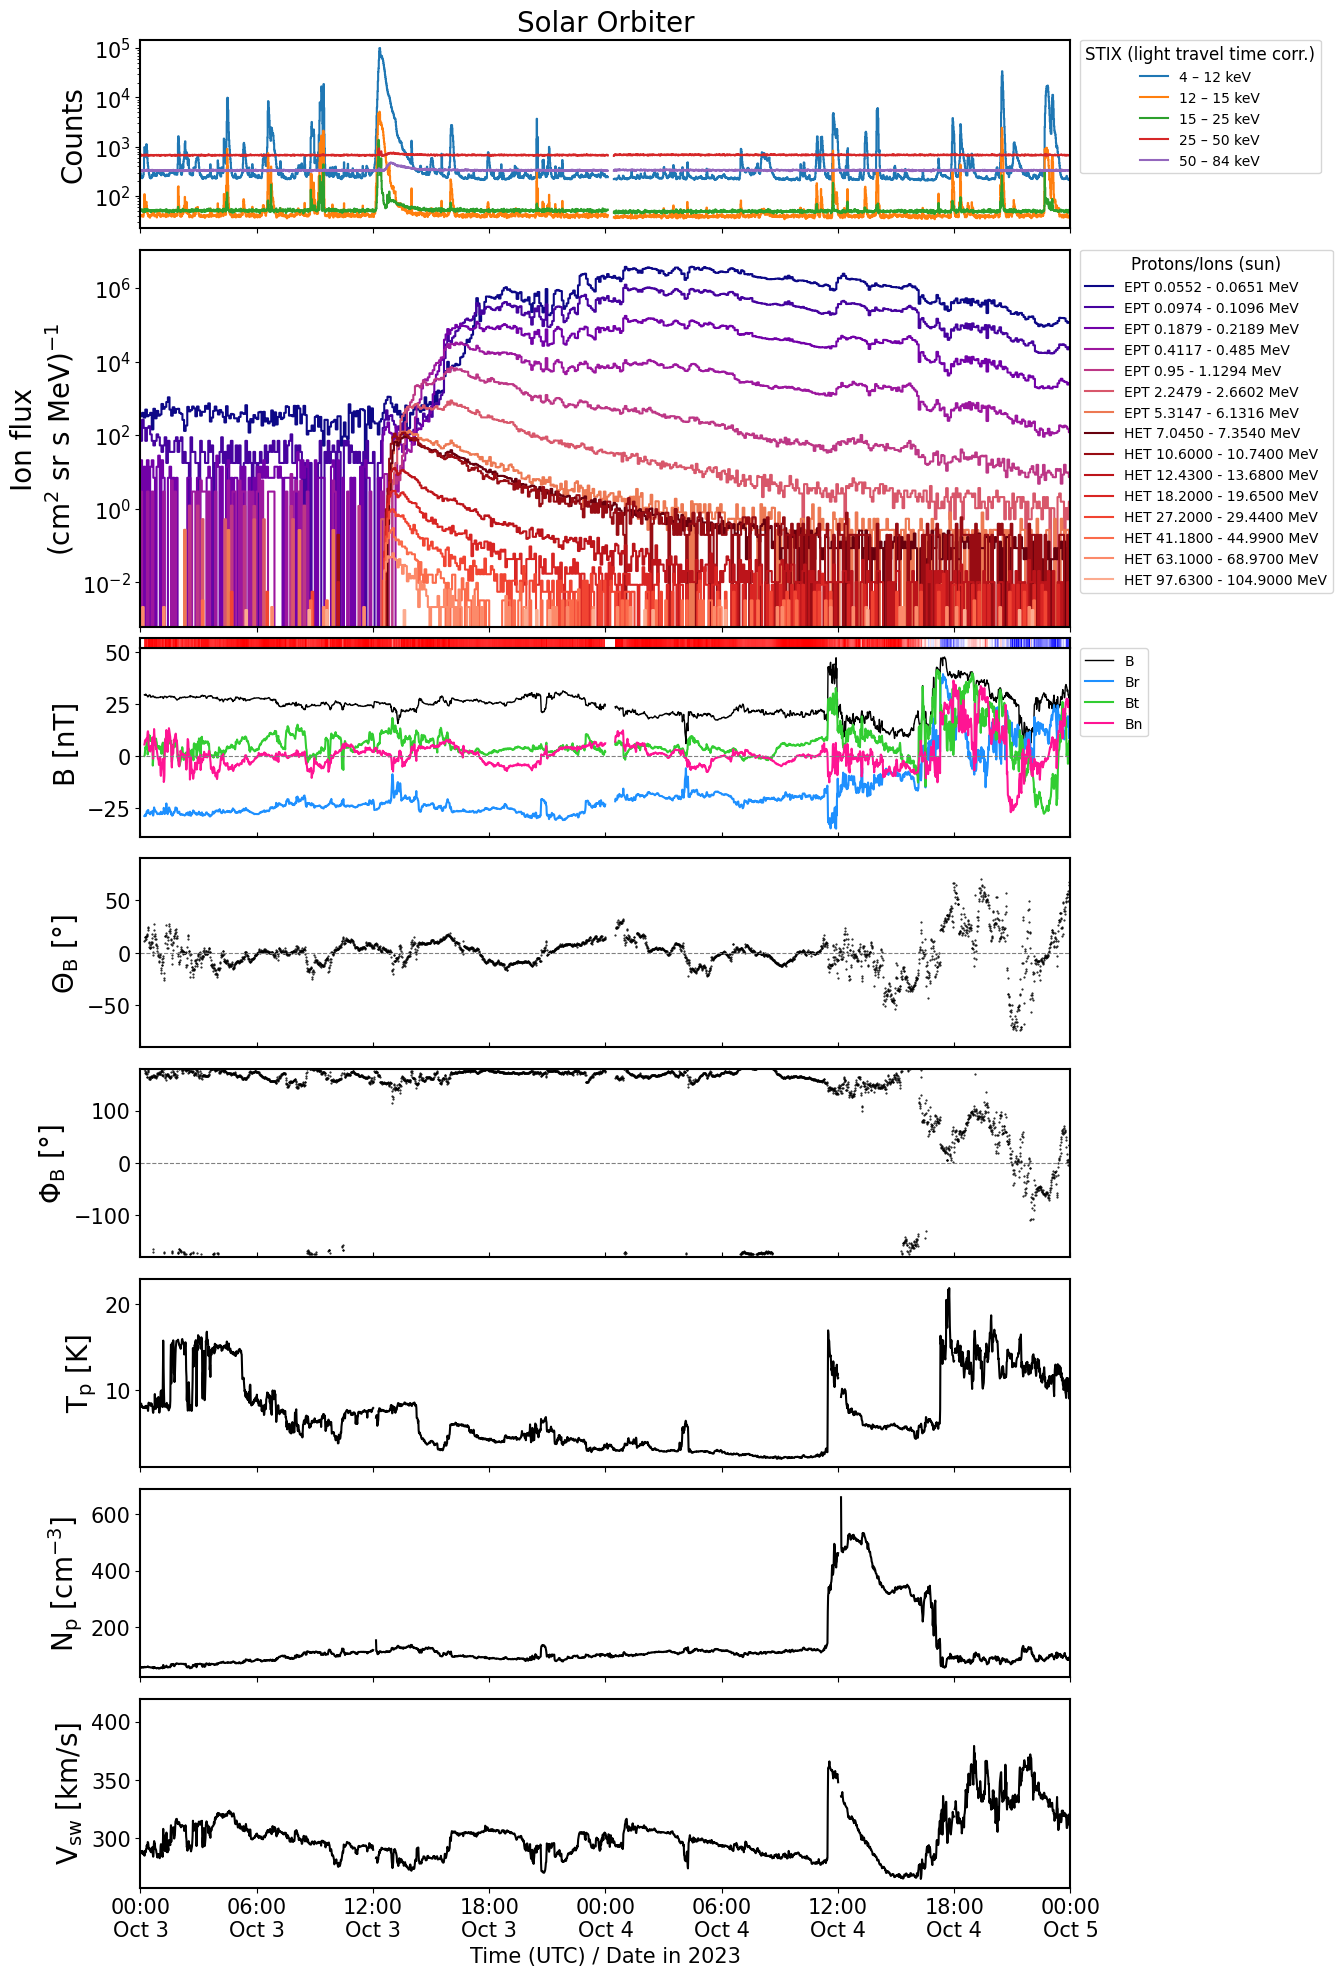

In [37]:
%matplotlib inline

panels = 1*plot_stix + 1*plot_electrons + 1*plot_protons + 2*plot_mag_angles + 1*plot_mag + 1* plot_Vsw + 1* plot_N + 1* plot_T

panel_ratios = list(np.zeros(panels)+1)
if plot_electrons and plot_protons:
    panel_ratios[0+1*plot_stix] = 2
    panel_ratios[1+1*plot_stix] = 2
if plot_electrons or plot_protons:    
    panel_ratios[0+1*plot_stix] = 2

i=0
if panels == 3:
    fig, axs = plt.subplots(nrows=panels, sharex=True, figsize=[12, 4*panels])#, gridspec_kw={'height_ratios': panel_ratios})# layout="constrained")
else:
    fig, axs = plt.subplots(nrows=panels, sharex=True, figsize=[12, 3*panels], gridspec_kw={'height_ratios': panel_ratios})# layout="constrained")

fig.subplots_adjust(hspace=0.1)

if panels == 1:
    axs = [axs, axs]

font_ylabel = 20
font_legend = 10
color_offset = 3

### STIX
if plot_stix:
    for key in df_stix.keys():
        axs[i].plot(df_stix.index, df_stix[key], ds="steps-mid", label=key)
    if stix_ltc:
        title = 'STIX (light travel time corr.)'
    else:
        title = 'STIX'
    axs[i].legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0., title=title, fontsize=font_legend, alignment='center')
    axs[i].set_ylabel('Counts', fontsize=font_ylabel)
    axs[i].set_yscale('log')
    i +=1 

### Electrons
ch_key = 'Electron_Bins_Text'
e_key = 'Electron_Flux'
p_key = 'Ion_Flux'
p_ch_key = "Ion_Bins_Text"
#e_channels = np.arange(0, 15, 3) #[2, 10, 19, 25]
if plot_electrons:        
    if av_en:
        ch_start = 0
        ch_end = len(energies_ept[ch_key])
        ch_step = 4
        num_channels = np.intc((ch_end-ch_start)/ch_step)
        axs[i].set_prop_cycle('color', plt.cm.Blues_r(np.linspace(0,1,num_channels+color_offset)))

        for k in np.arange(ch_start, ch_end-ch_step, ch_step):
            channel = [k, k+ch_step-1]
            av_flux, en_channel_string = calc_av_en_flux_EPD(df_electrons_ept, energies_ept, channel, 'e', 'ept')
            # av_flux, en_channel_string = combine_channels(df_electrons_ept, energies_ept, channel, 'ept', viewing=None, species='e')
            axs[i].plot(av_flux, ds="steps-mid", label='EPT '+en_channel_string)    

    else:
        if ept_l3:
            axs[i].set_prop_cycle('color', plt.cm.Blues_r(np.linspace(0,1,len(ept_ele_channels)+color_offset)))
            # for k, e in enumerate(energies_ept['Electron_Bins_Text']):
            for chan in ept_ele_channels:
                axs[i].plot(df_ept[f'Electron_Corrected_Flux_{view}_{chan}'], ds="steps-mid", label=f'EPT {energies_ept['Electron_Bins_Text'][chan]}') 
        else:
            ch_start = 0
            ch_end = len(energies_ept[ch_key])
            ch_step = 1
            for k in np.arange(ch_start, ch_end-ch_step, ch_step):
                if ion_conta_corr:
                    axs[i].plot(df_electrons_ept[f'{e_key}_{k}'],
                                ds="steps-mid", label='EPT '+energies_ept[ch_key][k][0]) 
                else:
                    axs[i].plot(df_electrons_ept['Electron_Flux'][f'{e_key}_{k}'],
                                ds="steps-mid", label='EPT '+energies_ept[ch_key][k][0])                  

    axs[i].set_prop_cycle('color', plt.cm.Greys_r(np.linspace(0.,1,len(het_ele_channels)+color_offset)))
    for channel in het_ele_channels:
        axs[i].plot(df_electrons_het['Electron_Flux'][f'{e_key}_{channel}'],
                    ds="steps-mid", label='HET '+energies_het[ch_key].flatten()[channel])
    axs[i].set_yscale('log')
    axs[i].set_ylabel("Electron flux\n"+r"(cm$^2$ sr s MeV)$^{-1}$", fontsize=font_ylabel)
    axs[i].legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0., title=f'Electrons ({viewing})', fontsize=font_legend)
    i += 1



### Protons
if plot_protons:
    if av_en:
        ch_start = 0
        ch_end = 64
        ch_step = 7
        num_channels = np.intc((ch_end-ch_start)/ch_step)
        axs[i].set_prop_cycle('color', plt.cm.plasma(np.linspace(0,1,num_channels+color_offset)))

        for k in np.arange(ch_start, ch_end-ch_step, ch_step):
            channel = [k, k+ch_step-1]
            av_flux, en_channel_string = calc_av_en_flux_EPD(df_protons_ept, energies_ept, channel, 'p', 'ept')
            # av_flux, en_channel_string = combine_channels(df_protons_ept, energies_ept, channel, 'ept', viewing=None, species='p')
            axs[i].plot(av_flux, ds="steps-mid", label='EPT '+en_channel_string)    

        ch_start = 0
        ch_end = len(energies_het['H_Bins_Text'])-1
        ch_step = 5
        num_channels = np.intc((ch_end-ch_start)/ch_step)                
        axs[i].set_prop_cycle('color', plt.cm.YlOrRd(np.linspace(0.3,1,num_channels)))
        for k in np.arange(ch_start, ch_end-ch_step, ch_step):
            channel = [k, k+ch_step-1]
            av_flux, en_channel_string = calc_av_en_flux_EPD(df_protons_het, energies_het, channel, 'p', 'het')
            # av_flux, en_channel_string = combine_channels(df_protons_het, energies_het, channel, 'het', viewing=None, species='p')
            axs[i].plot(av_flux, ds="steps-mid", label='HET '+en_channel_string)
        axs[i].set_yscale('log')
        axs[i].set_ylabel("Ion flux\n"+r"(cm$^2$ sr s MeV)$^{-1}$", fontsize=font_ylabel)
        axs[i].legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0., title=f'Protons/Ions ({viewing})', fontsize=font_legend)
        i += 1 

    else:
        if ept_l3:
            axs[i].set_prop_cycle('color', plt.cm.plasma(np.linspace(0,1,len(ept_ion_channels)+color_offset)))
            # for k, e in enumerate(energies_ept['Ion_Bins_Text']):
            for chan in ept_ion_channels:                    
                axs[i].plot(df_ept[f'Ion_Flux_{view}_{chan}'], ds="steps-mid", label=f'EPT {energies_ept['Ion_Bins_Text'][chan]}') 
        else:
            p_channels = np.arange(0, 64, 6)
            axs[i].set_prop_cycle('color', plt.cm.YlOrRd(np.linspace(0.2,1,len(p_channels))))
            for channel in p_channels:
                axs[i].plot(df_protons_ept['Ion_Flux'][f'{p_key}_{channel}'],
                            ds="steps-mid", label='EPT '+energies_ept[p_ch_key][channel][0])    
            
        axs[i].set_prop_cycle('color', plt.cm.Reds_r(np.linspace(0,1,len(het_ion_channels)+color_offset)))
        for channel in het_ion_channels:
            axs[i].plot(df_protons_het['H_Flux'][f'H_Flux_{channel}'],
                        ds="steps-mid", label='HET '+energies_het["H_Bins_Text"].flatten()[channel])
        axs[i].set_yscale('log')
        axs[i].set_ylabel("Ion flux\n"+r"(cm$^2$ sr s MeV)$^{-1}$", fontsize=font_ylabel)
        axs[i].legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0., title=f'Protons/Ions ({viewing})', fontsize=font_legend)
        i += 1    

    
### Mag
if plot_mag:
    ax = axs[i]
    # Bmag = np.sqrt(np.nansum((df_mag.B_r.values**2,mag_data.B_t.values**2,mag_data.B_n.values**2), axis=0))
    ax.plot(mag_data.index, mag_data.Bmag, label='B', color='k', linewidth=1)
    ax.plot(mag_data.index.values, mag_data.B_RTN_0.values, label='Br', color='dodgerblue')
    ax.plot(mag_data.index.values, mag_data.B_RTN_1.values, label='Bt', color='limegreen')
    ax.plot(mag_data.index.values, mag_data.B_RTN_2.values, label='Bn', color='deeppink')
    ax.axhline(y=0, color='gray', linewidth=0.8, linestyle='--')
    # ax.legend(loc='upper right')#, bbox_to_anchor=(1, 0.5))
    ax.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0., fontsize=font_legend)
    ax.set_ylabel('B [nT]', fontsize=font_ylabel)
    ax.tick_params(axis="x",direction="in", which='both')#, pad=-15)
    i += 1

if plot_polarity:
    pos = get_horizons_coord('Solar Orbiter', time={'start':mag_data.index[0]-pd.Timedelta(minutes=15), 'stop':mag_data.index[-1]+pd.Timedelta(minutes=15), 'step':"1min"})  # (lon, lat, radius) in (deg, deg, AU)
    pos = pos.transform_to(frames.HeliographicStonyhurst())
    #Interpolate position data to magnetic field data cadence
    r = np.interp([t.timestamp() for t in mag_data.index], [t.timestamp() for t in pd.to_datetime(pos.obstime.value)], pos.radius.value)
    lat = np.interp([t.timestamp() for t in mag_data.index], [t.timestamp() for t in pd.to_datetime(pos.obstime.value)], pos.lat.value)
    pol, phi_relative = polarity_rtn(mag_data.B_RTN_0.values, mag_data.B_RTN_1.values, mag_data.B_RTN_2.values, r, lat, V=400)
    # create an inset axe in the current axe:
    pol_ax = inset_axes(ax, height="5%", width="100%", loc=9, bbox_to_anchor=(0.,0,1,1.1), bbox_transform=ax.transAxes) # center, you can check the different codes in plt.legend?
    pol_ax.get_xaxis().set_visible(False)
    pol_ax.get_yaxis().set_visible(False)
    pol_ax.set_ylim(0,1)
    pol_ax.set_xlim([mag_data.index.values[0], mag_data.index.values[-1]])
    pol_arr = np.zeros(len(pol))+1
    timestamp = mag_data.index.values[2] - mag_data.index.values[1]
    norm = Normalize(vmin=0, vmax=180, clip=True)
    mapper = cm.ScalarMappable(norm=norm, cmap=cm.bwr)
    pol_ax.bar(mag_data.index.values[(phi_relative>=0) & (phi_relative<180)], pol_arr[(phi_relative>=0) & (phi_relative<180)], color=mapper.to_rgba(phi_relative[(phi_relative>=0) & (phi_relative<180)]), width=timestamp)
    pol_ax.bar(mag_data.index.values[(phi_relative>=180) & (phi_relative<360)], pol_arr[(phi_relative>=180) & (phi_relative<360)], color=mapper.to_rgba(np.abs(360-phi_relative[(phi_relative>=180) & (phi_relative<360)])), width=timestamp)
    pol_ax.set_xlim(startdate, enddate)

    
if plot_mag_angles:
    ax = axs[i]
    # Bmag = np.sqrt(np.nansum((mag_data.B_RTN_0.values**2,mag_data.B_RTN_1.values**2,mag_data.B_RTN_2.values**2), axis=0))    
    alpha, phi = mag_angles(mag_data['Bmag'], mag_data.B_RTN_0.values, mag_data.B_RTN_1.values, mag_data.B_RTN_2.values)
    ax.plot(mag_data.index, alpha, '.k', label='alpha', ms=1)
    ax.axhline(y=0, color='gray', linewidth=0.8, linestyle='--')
    ax.set_ylim(-90, 90)
    ax.set_ylabel(r"$\Theta_\mathrm{B}$ [°]", fontsize=font_ylabel)
    # ax.set_xlim(X1, X2)
    ax.tick_params(axis="x",direction="in", pad=-15)

    i += 1
    ax = axs[i]
    ax.plot(mag_data.index, phi, '.k', label='phi', ms=1)
    ax.axhline(y=0, color='gray', linewidth=0.8, linestyle='--')
    ax.set_ylim(-180, 180)
    ax.set_ylabel(r"$\Phi_\mathrm{B}$ [°]", fontsize=font_ylabel)
    # ax.set_xlim(X1, X2)
    ax.tick_params(axis="x",direction="in", which='both', pad=-15)
    i += 1
 
### Temperature
if plot_T:
    axs[i].plot(df_swa.index, df_swa['T'], '-k', label="Temperature")
    axs[i].set_ylabel(r"T$_\mathrm{p}$ [K]", fontsize=font_ylabel)
    i += 1

### Density
if plot_N:
    axs[i].plot(df_swa.index, df_swa.N,
                '-k', label="Ion density")
    axs[i].set_ylabel(r"N$_\mathrm{p}$ [cm$^{-3}$]", fontsize=font_ylabel)
    i += 1

### Sws
if plot_Vsw:
    axs[i].plot(df_swa.index, df_swa.vsw,
                '-k', label="Bulk speed")
    axs[i].set_ylabel(r"V$_\mathrm{sw}$ [km/s]", fontsize=font_ylabel)
    i += 1
  
axs[-1].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M\n%b %-d'))
axs[-1].xaxis.set_tick_params(rotation=0)
axs[-1].set_xlabel(f"Time (UTC) / Date in {startdate.year}", fontsize=15)
axs[-1].set_xlim(startdate, enddate)

axs[0].set_title('Solar Orbiter', ha='center')